In [33]:
cd /content/drive/My Drive/University/SEM7/CS4622_Machine_Learning/Project_1/Fair_Classification/

/content/drive/My Drive/University/SEM7/CS4622_Machine_Learning/Project_1/Fair_Classification


# Import Statements

In [0]:
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians,asin
import folium
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
from folium.plugins import TimestampedGeoJson
from folium.plugins import MarkerCluster
from geopy.distance import great_circle
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import Imputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle
from geopy.distance import geodesic

# Load Data

In [83]:
train  = pd.read_csv("/content/drive/My Drive/University/SEM7/CS4622_Machine_Learning/Project_1/Fair_Classification/train.csv")
test  = pd.read_csv("/content/drive/My Drive/University/SEM7/CS4622_Machine_Learning/Project_1/Fair_Classification/test.csv")

train.describe()


,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare
count,1.717600e+04,16974.000000,16974.000000,16974.000000,16974.000000,16974.000000,17176.000000,17176.000000,17176.000000,17176.000000,17039.000000
mean,2.014549e+08,13.719651,1702.858077,629.074231,32.057666,112.466832,6.965499,79.998389,6.968587,79.997534,312.655466
std,7.456830e+06,98.975052,8120.160818,8063.260669,465.483573,442.054812,0.210760,0.243384,0.378669,0.359648,605.300565
min,1.891236e+08,0.000000,0.000000,0.000000,0.000000,0.000000,5.937600,79.819100,5.941860,45.307700,0.000000
25%,1.947619e+08,10.500000,548.000000,33.000000,0.000000,26.000000,6.865077,79.870400,6.865625,79.870100,125.515000
50%,2.013582e+08,10.500000,1009.500000,123.000000,0.116600,73.000000,6.914105,79.898600,6.916160,79.899100,211.180000
75%,2.083081e+08,10.500000,1803.000000,351.000000,14.341800,144.000000,7.043057,79.956600,7.047195,79.960225,366.465000
max,2.138173e+08,12795.030000,453872.000000,453650.000000,26198.601400,51288.000000,8.051010,81.009600,48.132000,81.009700,26945.990000


In [61]:
test.describe()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare
count,8.576000e+03,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000
mean,2.180067e+08,11.088095,1541.590485,508.502099,24.671655,119.863106,6.969246,80.008728,6.970008,80.010145,293.278057
std,2.789252e+06,5.359602,5952.458574,5784.005855,333.515641,793.233190,0.217809,0.251873,0.218826,0.252229,436.730282
min,2.132846e+08,0.000000,0.000000,0.000000,0.000000,0.000000,5.943130,79.817700,5.936600,79.818000,0.000000
25%,2.156247e+08,10.500000,540.000000,30.000000,0.000000,26.000000,6.864810,79.871600,6.864950,79.871300,126.077500
50%,2.179006e+08,10.500000,982.500000,116.000000,0.000000,72.000000,6.913605,79.900500,6.915460,79.902250,203.950000
75%,2.203904e+08,10.500000,1723.000000,336.250000,11.744200,138.000000,7.068875,79.963225,7.073505,79.967825,344.075000
max,2.228607e+08,160.500000,447230.000000,446934.000000,25760.361800,55571.000000,8.425010,80.776400,8.421730,80.805500,26844.330000


# Feature Engineering

In [84]:
print('Old size: %d' % len(train))
train = train[np.abs(train.additional_fare-train.additional_fare.mean()) <= (3*train.additional_fare.std())]
print('New size: %d' % len(train))

Old size: 17176
New size: 16972


In [85]:
print('Old size: %d' % len(train))
train = train[np.abs(train.duration-train.duration.mean()) <= (3*train.duration.std())]
print('New size: %d' % len(train))

Old size: 16972
New size: 16918


In [86]:
print('Old size: %d' % len(train))
train = train[np.abs(train.fare-train.fare.mean()) <= (3*train.fare.std())]
print('New size: %d' % len(train))

Old size: 16918
New size: 16620


In [87]:
print('Old size: %d' % len(train))
train = train[np.abs(train.meter_waiting_till_pickup	-train.meter_waiting_till_pickup.mean()) <= (3*train.meter_waiting_till_pickup.std())]
print('New size: %d' % len(train))

Old size: 16620
New size: 16607


In [88]:
print('Old size: %d' % len(train))
train = train[np.abs(train.meter_waiting_fare	-train.meter_waiting_fare.mean()) <= (3*train.meter_waiting_fare.std())]
print('New size: %d' % len(train))

Old size: 16607
New size: 16290


In [89]:
print('Old size: %d' % len(train))
train = train[np.abs(train.meter_waiting-train.meter_waiting.mean()) <= (3*train.meter_waiting.std())]
print('New size: %d' % len(train))

Old size: 16290
New size: 15890


In [0]:
train['pickup_time']=pd.to_datetime(train['pickup_time'],infer_datetime_format=True)
train['drop_time']=pd.to_datetime(train['drop_time'],infer_datetime_format=True)

test['pickup_time']=pd.to_datetime(test['pickup_time'],infer_datetime_format=True)
test['drop_time']=pd.to_datetime(test['drop_time'],infer_datetime_format=True)

In [0]:
train['pickup_date']= train['pickup_time'].dt.date
train['pickup_day']=train['pickup_time'].apply(lambda x:x.day)
train['pickup_hour']=train['pickup_time'].apply(lambda x:x.hour)
train['pickup_day_of_week']=train['pickup_time'].apply(lambda x:calendar.day_name[x.weekday()])
train['pickup_month']=train['pickup_time'].apply(lambda x:x.month)
train['pickup_year']=train['pickup_time'].apply(lambda x:x.year)

test['pickup_date']= test['pickup_time'].dt.date
test['pickup_day']=test['pickup_time'].apply(lambda x:x.day)
test['pickup_hour']=test['pickup_time'].apply(lambda x:x.hour)
test['pickup_day_of_week']=test['pickup_time'].apply(lambda x:calendar.day_name[x.weekday()])
test['pickup_month']=test['pickup_time'].apply(lambda x:x.month)
test['pickup_year']=test['pickup_time'].apply(lambda x:x.year)

In [0]:
def encodeDays(day_of_week):
  day_dict={'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
  return day_dict[day_of_week]
def encodeLabel(label):
  label_dict={'correct':1,'incorrect':0}
  return label_dict[label]
def clean_data(data,isTrain):
  data['pickup_day_of_week']=data['pickup_day_of_week'].apply(lambda x:encodeDays(x))
  if(isTrain):
    data['label']=data['label'].apply(lambda x:encodeLabel(x))
  return data

In [93]:
train=clean_data(train,True)
test=clean_data(test,False)
print("Shape of Training Data after cleaning ",train.shape)
print("Shape of Testing Data after cleaning", test.shape)

Shape of Training Data after cleaning  (15890, 20)
Shape of Testing Data after cleaning (8576, 19)


# EDA

In [94]:
test[pd.isnull(test)].sum()

tripid                       0.0
additional_fare              0.0
duration                     0.0
meter_waiting                0.0
meter_waiting_fare           0.0
meter_waiting_till_pickup    0.0
pickup_time                  0.0
drop_time                    0.0
pick_lat                     0.0
pick_lon                     0.0
drop_lat                     0.0
drop_lon                     0.0
fare                         0.0
pickup_date                  0.0
pickup_day                   0.0
pickup_hour                  0.0
pickup_day_of_week           0.0
pickup_month                 0.0
pickup_year                  0.0
dtype: float64

Text(0.5, 1.0, 'Distribution of Trip Fare')

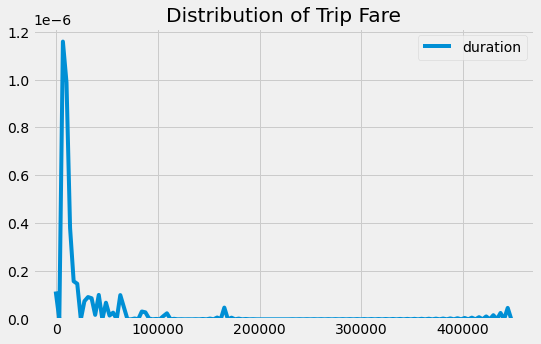

In [19]:
plt.figure(figsize=(8,5))
sns.kdeplot(test['duration']).set_title("Distribution of Trip Fare")

In [22]:
train.loc[train['meter_waiting_till_pickup']<0].shape

(0, 20)

In [0]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train['fare'].values)).set_title("Distribution of fare amount (log scale)")

In [47]:
print("Range of Pickup Longitude is ", (min(test['drop_lon']),max(test['drop_lon'])))
print("Range of Pickup Latitude is ", (min(test['pick_lat']),max(test['pick_lat'])))
test[(test.pick_lat==0) | (test.pick_lon)==0 | (test.drop_lat==0)|(test.drop_lon==0)].shape

Range of Pickup Longitude is  (79.818, 80.8055)
Range of Pickup Latitude is  (5.94313, 8.42501)


(0, 19)

In [0]:
boundary={'min_lng':79.818,
              'min_lat':5.94313,
              'max_lng':80.8055, 
              'max_lat':8.42501}

In [96]:
train.loc[~((train.pick_lon >= boundary['min_lng'] ) & (train.pick_lon <= boundary['max_lng']) &
            (train.pick_lat >= boundary['min_lat']) & (train.pick_lat <= boundary['max_lat']) &
            (train.drop_lon >= boundary['min_lng']) & (train.drop_lon <= boundary['max_lng']) &
            (train.drop_lat >=boundary['min_lat']) & (train.drop_lat <= boundary['max_lat'])),'is_outlier_loc']=1
train.loc[((train.pick_lon >= boundary['min_lng'] ) & (train.pick_lon <= boundary['max_lng']) &
            (train.pick_lat >= boundary['min_lat']) & (train.pick_lat <= boundary['max_lat']) &
            (train.drop_lon >= boundary['min_lng']) & (train.drop_lon <= boundary['max_lng']) &
            (train.drop_lat >=boundary['min_lat']) & (train.drop_lat <= boundary['max_lat'])),'is_outlier_loc']=0

print("Outlier vs Non Outlier Counts")
print(train['is_outlier_loc'].value_counts())

print('Old size: %d' % len(train))
# Let us drop rows, where location is outlier
train=train.loc[train['is_outlier_loc']==0]
train.drop(['is_outlier_loc'],axis=1,inplace=True)
train = train[train.duration>=0]
print('New size: %d' % len(train))

Outlier vs Non Outlier Counts
0.0    15883
1.0    7    
Name: is_outlier_loc, dtype: int64
Old size: 15890
New size: 15883


(5.9366, 8.42173)

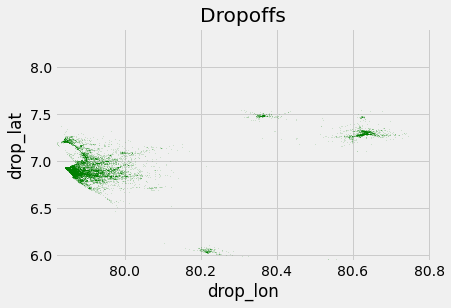

In [97]:
city_long_border = (79.818, 80.8055)
city_lat_border = (5.9366, 8.42173)

train.plot(kind='scatter', x='drop_lon', y='drop_lat',
                color='green', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.xlim(city_long_border)
plt.ylim(city_lat_border)


(79.818, 80.8055)

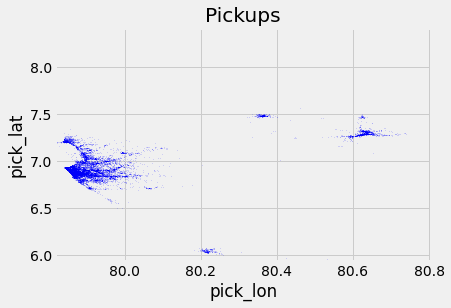

In [32]:
train.plot(kind='scatter', x='pick_lon', y='pick_lat',
                color='blue', 
                s=.02, alpha=.6)
plt.title("Pickups")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

In [98]:
print('Old size: %d' % len(train))
train = train[train.fare>=0]
print('New size: %d' % len(train))

Old size: 15883
New size: 15883


In [99]:
print('Old size: %d' % len(train))
train = train[train.duration>=0]
print('New size: %d' % len(train))

Old size: 15883
New size: 15883


In [100]:
print('Old size: %d' % len(train))
train = train.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train))

Old size: 15883
New size: 15883


In [0]:
train['pickup_latitude_round3']=train['pick_lat'].apply(lambda x:round(x,3))
train['pickup_longitude_round3']=train['pick_lon'].apply(lambda x:round(x,3))
train['dropoff_latitude_round3']=train['drop_lat'].apply(lambda x:round(x,3))
train['dropoff_longitude_round3']=train['drop_lon'].apply(lambda x:round(x,3))

In [0]:
pickup_fare_amount=train.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['fare'].mean().reset_index().rename(columns={'fare':'avg_fare'})
pickup_fare_amount.head()

,pickup_latitude_round3,pickup_longitude_round3,avg_fare
0,5.938,80.513,219.010
1,5.944,80.549,142.870
2,5.945,80.549,241.745
3,5.945,80.550,165.760
4,5.945,80.553,162.660


# Trip Distance

In [0]:
#calculate trip distance in miles
def distance(lat1, lat2, lon1,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [0]:
train['trip_distance']=train.apply(lambda row:distance(row['pick_lat'],row['drop_lat'],row['pick_lon'],row['drop_lon']),axis=1)
test['trip_distance']=test.apply(lambda row:distance(row['pick_lat'],row['drop_lat'],row['pick_lon'],row['drop_lon']),axis=1)

Text(0.5, 1.0, 'Distribution of Trip Distance (log scale)')

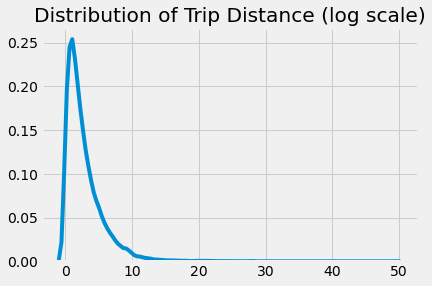

In [0]:
sns.kdeplot(train['trip_distance'].values).set_title("Distribution of Trip Distance (log scale)")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount')

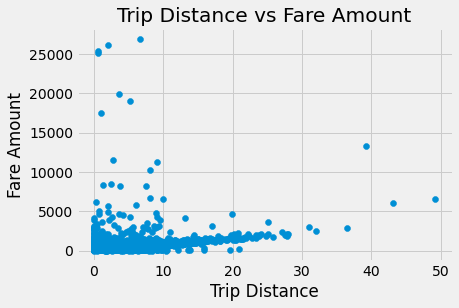

In [0]:
plt.scatter(x=train['trip_distance'],y=train['fare'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount")

In [0]:
# train.to_csv("Train_FeatureEngineering_2.csv",index=False)
test.to_csv("Test_FeatureEngineering_2.csv",index=False)

In [0]:
test.head

<bound method NDFrame.head of          tripid  additional_fare  duration  ...  drop_lat  drop_lon     fare
0     213284604  10.5             924       ...  6.77490   79.8840   289.27 
1     213286352  10.5             4249      ...  6.55091   79.9706   1912.70
2     213293973  10.5             1552      ...  6.90539   79.8989   394.00 
3     213294622  10.5             462       ...  6.80401   79.9407   154.32 
4     213298687  10.5             814       ...  6.98875   79.8914   147.47 
...         ...   ...             ...       ...      ...       ...      ... 
8571  222856243  10.5             1723      ...  6.85588   79.9214   388.48 
8572  222857785  10.5             1378      ...  6.92112   79.8980   379.85 
8573  222858416  10.5             418       ...  6.83868   79.9083   112.79 
8574  222858691  10.5             1604      ...  6.93159   79.9145   248.46 
8575  222860703  10.5             1698      ...  6.87020   79.9340   339.63 

[8576 rows x 13 columns]>